In [12]:
from plotnine import *
import pandas as pd
import numpy as np
import ipywidgets as widgets
from data.mock_data_generator import generate_mock_data
import matplotlib.pyplot as plt
from model.model_creator import create_model
from model.solution_parser import parse_solution
from visualization.data_visualizer  import  visualize_data

# Data

Data contains transaction log of the past 1 year, and records are classified by the type of expenditure:
1. grocery
2. fashion
3. household
4. online shopping
5. travels

Let's assume that there is associated importance with each transaction record. This can be of direct dependency of type field, manually labeled or learned (separate task)

| info     |  type  | amount | importance | week |
|----------|--------|--------|------------|------|
| Lidl     |   1    |  60.0  |     1      |  3   |
| Zalando  |   2    |  45.0  |     2      |  28  |
| Rent Aug |   3    | 1450.0 |     10     |  17  | 



In [13]:
data = generate_mock_data(350)

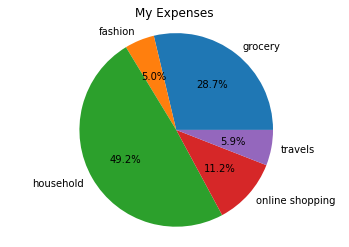

Total expenses for the year are 29281.35 Euros


In [14]:
visualize_data(data)

# Problem
You would like to understand which type of expenses you need to cut in future in order to achieve a certain savings per year.
Given a savings amount X, you need to return a list of transactions with minimal total importance, which you could have cut during current year, in order to save this amount.

Sanity rules:
* You know that there is a certain amount you need to spend on groceries (you need to eat)
* Every season you need to spend a certain amount on clothing 
* In general, you cannot avoid paying for household 


# Model
### Decision
Take or not to take the corresponding transaction. Let transaction be indexed by $n \in \mathcal{N}$. Then the decision variable, corresponding to taking or not taking transaction $n$ is $z_n \in \{0,1\}$

### Optimization goal, i.e. objective function
We want to minimize the total importance of all the transaction we decide to remove, in order to achieve certain savings goal. If $I_n$ is importance of transaction $n$, then our goal is to
\begin{align*}
\min \sum_{n \in N} I_n z_n
\end{align*}


Model inputs

In [15]:
savings = 0.4
grocery_per_week = 50.0

### Solving the problem

In [16]:
model, decision_vars = create_model(data, savings, grocery_per_week)

In [17]:
model.solve()


1

In [18]:
solution, obj = parse_solution(data, decision_vars, model)

In [19]:
solved_data = data.join(solution)

# Analyze solution

In [20]:
sum(solved_data['solution']*solved_data['amount'])

17567.829999999994

In [21]:
transactions_remained = solved_data['solution'] == 1

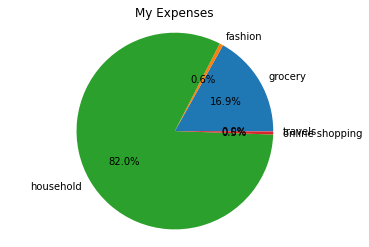

Total expenses for the year are 17567.83 Euros


In [22]:
visualize_data(data[transactions_remained])

## Check grocery expenses per week

In [23]:
before = solved_data[(solved_data['type']==1) ].groupby('week')['amount'].sum()
after = solved_data[(solved_data['solution']==1) & (solved_data['type']==1) ].groupby('week')['amount'].sum()
comparison = pd.DataFrame({"original":before, "optimized" :after})

<AxesSubplot:xlabel='week'>

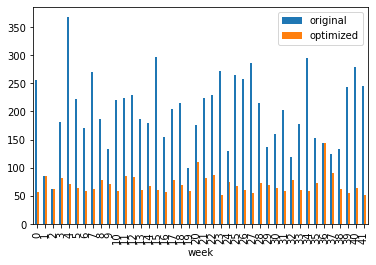

In [24]:
comparison.plot.bar()

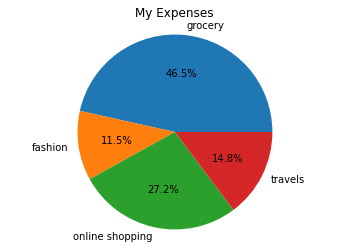

Total expenses for the year are 11713.52 Euros


In [25]:
visualize_data(data[~transactions_remained])

In [26]:
data[~transactions_remained]

,info,type,amount,week,importance
0,Amazon,4,43.93,39,5
2,Booking.com,5,888.09,23,8
3,Lidl,1,27.01,13,4
4,Edeka,1,32.24,6,0
6,Rewe,1,32.27,29,4
...,...,...,...,...,...
357,Aldi,1,38.08,22,2
358,Lidl,1,39.97,16,8
359,Amazon,4,33.80,10,6
360,Lidl,1,15.66,41,1
